# PART 1: SETUP & PREPROCESSING

### Import Required Libraries

In [1]:
"""
Explainable Image Classification on CIFAR-10

This notebook implements the complete pipeline for 
1. Model Selection and Training (ResNet-50)
2. Data Preprocessing (CIFAR-10)
3. Fine-Tuning with Transfer Learning
4. XAI Explanations (Grad-CAM and LIME)
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS (Apple Silicon GPU) available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

Libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: False
MPS (Apple Silicon GPU) available: True
MPS built: True


### Device Setup

In [2]:
def setup_device():
    """
    Configure the computation device for optimal performance.
    
    Device Priority:
    1. MPS (Metal Performance Shaders) - Apple Silicon GPU (M1/M2/M3)
    2. CUDA - NVIDIA GPU
    3. CPU - Fallback option
    
    Returns:
        torch.device: The device to be used for tensor operations
    """
    # Check for Apple Silicon GPU (MPS)
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
        print("\n" + "="*80)
        print("DEVICE CONFIGURATION")
        print("="*80)
        print("Using: Apple Silicon GPU (Metal Performance Shaders)")
        print("✓ M1/M2/M3/M4 GPU acceleration enabled")
        print("✓ Unified memory architecture optimized")
    # Check for NVIDIA GPU (CUDA)
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("\n" + "="*80)
        print("DEVICE CONFIGURATION")
        print("="*80)
        print(f"Using: NVIDIA GPU - {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print("✓ CUDA acceleration enabled")
    # Fallback to CPU
    else:
        device = torch.device("cpu")
        print("\n" + "="*80)
        print("DEVICE CONFIGURATION")
        print("="*80)
        print("Using: CPU")
        print("⚠️ GPU acceleration not available - training will be slower")
        print("Consider using Google Colab for free GPU access")
    
    print("="*80)
    return device

# Initialize device
device = setup_device()


DEVICE CONFIGURATION
Using: Apple Silicon GPU (Metal Performance Shaders)
✓ M1/M2/M3/M4 GPU acceleration enabled
✓ Unified memory architecture optimized


### Dataset Loadin and Preprocessing 

In [3]:
def load_cifar10_data(batch_size=64, num_workers=0):
    """
    Load and preprocess CIFAR-10 dataset for ResNet-50.
    
    Dataset: 60,000 images (32×32) in 10 classes
    Preprocessing: Resize to 224×224, ImageNet normalization
    Split: 40k train / 10k validation / 10k test
    
    Args:
        batch_size (int): Samples per batch (64 optimal for M1)
        num_workers (int): Data loading threads (0 for MPS)
    
    Returns:
        tuple: (train_loader, val_loader, test_loader, class_names)
    """
    # ImageNet normalization constants
    # RGB channel means: Red=0.485, Green=0.456, Blue=0.406
    mean = [0.485, 0.456, 0.406]
    # RGB channel standard deviations: Red=0.229, Green=0.224, Blue=0.225
    std = [0.229, 0.224, 0.225]

   # Training augmentation pipeline (increases dataset diversity, prevents overfitting)
    train_transform = transforms.Compose([
        transforms.Resize(224),  # Resize to 224×224
        transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of images horizontally
        transforms.RandomCrop(224, padding=4),   # Random crop with 4-pixel padding for slight variations
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness/contrast adjustment (±20%)n
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean, std)  # Normalize using ImageNet statistics (required for pretrained models)
    ])
    # Validation/test transform (no augmentation, only preprocessing)
    test_transform = transforms.Compose([
        transforms.Resize(224), # Resize to 224×224
        transforms.ToTensor(), # Convert to tensor [0, 1]
        transforms.Normalize(mean, std) # Normalize using ImageNet statistics
    ])
    # Download CIFAR-10
    print("Loading CIFAR-10 dataset...")
    train_val_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )
    
    test_dataset = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )

    # Split train into train/val (80/20)
    train_size = int(0.8*len(train_val_dataset)) # 40,000 training samples
    val_size = len(train_val_dataset) - train_size # 10,000 validation samples
    # Perform random split with fixed seed for reproducibility
    train_dataset, val_dataset = random_split(
        train_val_dataset, # Dataset to split (50,000 images)
        [train_size, val_size], # Split sizes [40,000, 10,000]
        generator=torch.Generator().manual_seed(42) # Fixed seed for reproducible splits
    )

    # Apply test transform to validation set (remove augmentation)
    # Validation should not have data augmentation like training set
    val_dataset.dataset = datasets.CIFAR10(
        root='./data',
        train=True, # Use training set pool
        download=False,
        transform=test_transform # Apply test transform (no augmentation)
    )

    # Create training data loader (shuffled batches for training)
    train_loader = DataLoader(
        train_dataset, # Training dataset (40,000 samples)
        batch_size=batch_size, # Number of samples per batch (64)
        shuffle=True, # Shuffle data every epoch (prevents learning order)
        num_workers=num_workers, # Number of subprocesses for data loading
        pin_memory=False  # Not needed for MPS
    )
    # Create validation data loader (no shuffling needed)
    val_loader = DataLoader(
        val_dataset, # Validation dataset (10,000 samples)
        batch_size=batch_size, # Batch size (64)
        shuffle=False, # No shuffling for validation (order doesn't matter)
        num_workers=num_workers,# Data loading threads (0)
        pin_memory=False # Not needed for MPS
    )
    # Create test data loader (no shuffling needed)
    test_loader = DataLoader(
        test_dataset, # Test dataset (10,000 samples)
        batch_size=batch_size, # Batch size (64)
        shuffle=False, # No shuffling for test set
        num_workers=num_workers, # Data loading threads (0)
        pin_memory=False # Not needed for MPS
    )

    # Class names
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Print statistics
    print(f"\nDataset Statistics:")
    print(f"  Training samples: {len(train_dataset):,}")
    print(f"  Validation samples: {len(val_dataset):,}")
    print(f"  Test samples: {len(test_dataset):,}")
    print(f"  Number of classes: {len(classes)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Image size: 224×224×3")
    print(f"  Normalization: mean={mean}, std={std}")
    
    return train_loader, val_loader, test_loader, classes
# Load CIFAR-10 data
train_loader, val_loader, test_loader, class_names = load_cifar10_data(batch_size=64, num_workers=0)

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified

Dataset Statistics:
  Training samples: 40,000
  Validation samples: 10,000
  Test samples: 10,000
  Number of classes: 10
  Batch size: 64
  Image size: 224×224×3
  Normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]


### Visualize Sample Images


Visualizing training samples:


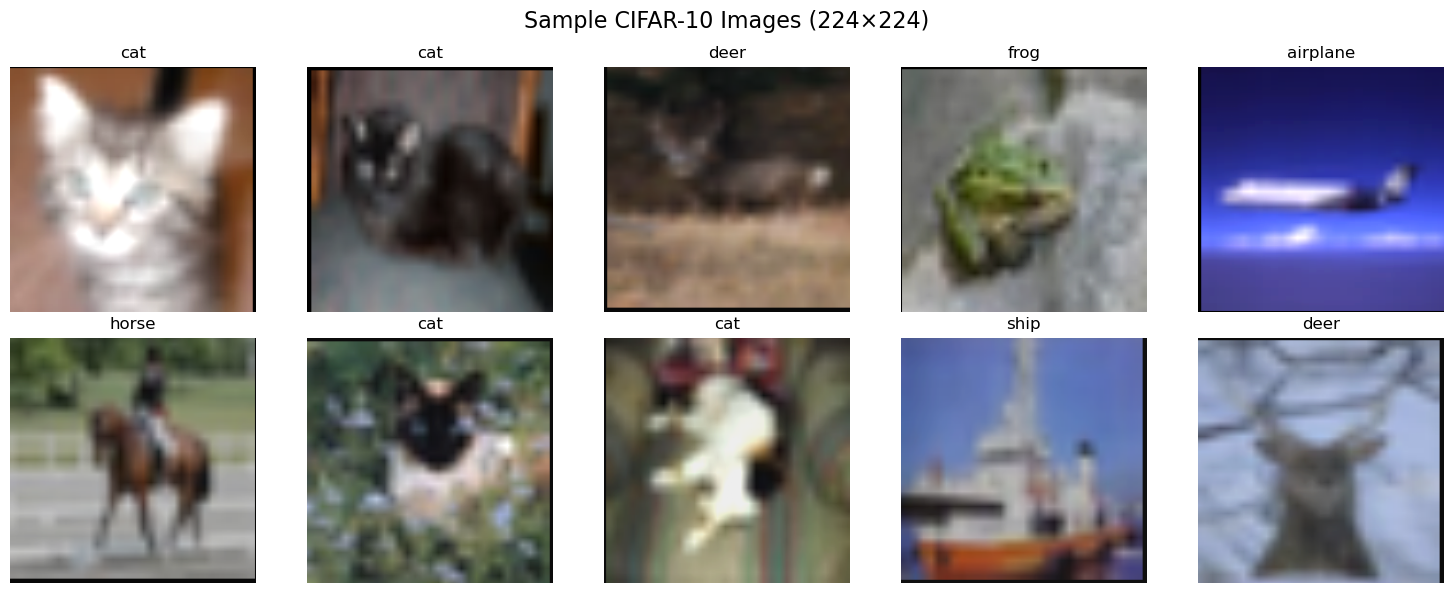

In [4]:
def visualize_cifar10_samples(loader, classes, num_samples=10):
    """
    Display random CIFAR-10 samples after preprocessing.
    
    Args:
        loader (DataLoader): Data loader
        classes (list): Class names
        num_samples (int): Number of samples to display
    """
    # Get batch
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Denormalization constants
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Create subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Sample CIFAR-10 Images (224×224)', fontsize=16)
    
    for idx in range(num_samples):
        ax = axes[idx // 5, idx % 5]
        
        # Denormalize
        img = images[idx] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
        # Display
        ax.imshow(img)
        ax.set_title(f'{classes[labels[idx]]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
print("\nVisualizing training samples:")
visualize_cifar10_samples(train_loader, class_names)

# PART 2: MODEL ARCHITECTURE

### Load Pretrained ResNet-50

In [5]:
def load_pretrained_resnet50(num_classes=10, pretrained=True, use_dropout=True):
    """
    Load ResNet-50 with optional DROPOUT for regularization.
    
    Args:
        num_classes (int): Output classes (10 for CIFAR-10)
        pretrained (bool): Load ImageNet weights
        use_dropout (bool): Add dropout layer before final FC
    
    Returns:
        nn.Module: Modified ResNet-50
    """
    print("Loading ResNet-50 model...")
    
    # Load pretrained model
    if pretrained:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        print("  ✓ Loaded ImageNet pretrained weights")
    else:
        model = models.resnet50(weights=None)
        print("  ✓ Initialized with random weights")
    
    # Replace final FC layer with DROPOUT
    num_features = model.fc.in_features
    
    if use_dropout:
        # Add Dropout before final layer
        model.fc = nn.Sequential(
            nn.Dropout(p=0.5),  # Drop 50% of neurons randomly
            nn.Linear(num_features, num_classes)
        )
        print(f"\n  ✓ Replaced FC layer with Dropout: {num_features} → Dropout(0.5) → {num_classes} classes")
    else:
        # Original (no dropout)
        model.fc = nn.Linear(num_features, num_classes)
        print(f"\n  ✓ Replaced FC layer: {num_features} → {num_classes} classes")
    
    # Calculate parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nParameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")
    print(f"  Dropout enabled: {use_dropout}")
    
    return model

# Usage: Load model with dropout
model = load_pretrained_resnet50(num_classes=10, pretrained=True, use_dropout=True)
model = model.to(device)

Loading ResNet-50 model...
  ✓ Loaded ImageNet pretrained weights

  ✓ Replaced FC layer with Dropout: 2048 → Dropout(0.5) → 10 classes

Parameters:
  Total: 23,528,522
  Trainable: 23,528,522
  Dropout enabled: True


### Training Configuration

In [6]:
def configure_training(model, learning_rate=0.0005):
    """
    Configure loss function, optimizer, and learning rate scheduler.
    
    Strategy: Fine-tune all layers with Adam optimizer
    Loss: CrossEntropyLoss for multi-class classification
    Scheduler: ReduceLROnPlateau (reduce LR when validation loss plateaus)
    
    Args:
        model (nn.Module): The model to train
        learning_rate (float): Initial learning rate
    
    Returns:
        tuple: (criterion, optimizer, scheduler)
    """
    # Define loss function for multi-class classification
    # CrossEntropyLoss combines LogSoftmax and NLLLoss
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Prevent overconfidence 
    
    # Configure Adam optimizer (adaptive learning rate optimization)
    # Optimizes all model parameters (full fine-tuning)
    optimizer = optim.Adam(
        # All model parameters will be updated
        model.parameters(),
        # Initial learning rate
        lr=learning_rate,
        # Weight decay for L2 regularization (prevents overfitting)
        weight_decay=5e-4
    )
    
    # Learning rate scheduler (reduces LR when validation loss plateaus)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        # Optimizer to adjust
        optimizer,
        # Minimize validation loss
        mode='min',
        # Reduce LR by factor of 0.1 when plateau detected
        factor=0.1,
        # Wait 3 epochs before reducing LR
        patience=3,
        # Verbose output when LR changes
        verbose=True
    )
    
    print("\n" + "="*80)
    print("TRAINING CONFIGURATION")
    print("="*80)
    print(f"Loss Function: CrossEntropyLoss")
    print(f"Optimizer: Adam")
    print(f"Learning Rate: {learning_rate}")
    print(f"Weight Decay: 1e-4")
    print(f"LR Scheduler: ReduceLROnPlateau (factor=0.1, patience=3)")
    print(f"Training Strategy: Full fine-tuning (all layers trainable)")
    print("="*80)
    
    return criterion, optimizer, scheduler

# Configure training components
criterion, optimizer, scheduler = configure_training(model, learning_rate=0.0005)


TRAINING CONFIGURATION
Loss Function: CrossEntropyLoss
Optimizer: Adam
Learning Rate: 0.0005
Weight Decay: 1e-4
LR Scheduler: ReduceLROnPlateau (factor=0.1, patience=3)
Training Strategy: Full fine-tuning (all layers trainable)


/opt/anaconda3/envs/in3050/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# PART 3: TRAINING & FINE-TUNING

### Training Functions

In [7]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, clip_grad=1.0):
    """
    Train the model for one epoch.
    
    Process:
    1. Set model to training mode
    2. Iterate through batches
    3. Forward pass → compute loss → backward pass → update weights
    4. Track loss and accuracy
    
    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to use (MPS/CUDA/CPU)
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    # Set model to training mode 
    model.train()
    running_loss = 0.0
    correct = 0 # Correct predictions counter
    total = 0

    # Create progress bar for training batches
    train_pbar = tqdm(train_loader, desc='Training', leave=False)

    # Iterate trhough traning batches 
    for inputs, labels in train_pbar:
        # Move inputs for device 
        inputs = inputs.to(device)
        # Move labels to device
        labels = labels.to(device)

        # Zero the parameter gradients (clear previous gradients)
        optimizer.zero_grad()
        # Forward pass. compute model predicitons
        outputs = model(inputs)
        # Compute loss between predictions and true labels
        loss = criterion(outputs, labels)
        # Backward pass: compute gradients 
        loss.backward()
         # GRADIENT CLIPPING (prevents exploding gradients)
        if clip_grad > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        # Update model parameters using computed gradients
        optimizer.step()

        # Accumulate loss 
        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy 
        # Get predicted class (highest probability)
        _, predicted = torch.max(outputs,1)
        # Count total samples in batch
        total += labels.size(0)
        # Count correct predictions 
        correct += (predicted == labels).sum().item()

        # Update progress bar with current metrics
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * correct / total:.2f}%'
        })
    # Calculate epoch metric
    # Average loss across all samples
    epoch_loss = running_loss / total
    # Accuracy as percentage
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """
    Validate the model on validation set.
    
    Process:
    1. Set model to evaluation mode
    2. Disable gradient computation
    3. Iterate through batches
    4. Compute loss and accuracy
    
    Args:
        model (nn.Module): The model to validate
        val_loader (DataLoader): Validation data loader
        criterion: Loss function
        device: Device to use
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    # Set model to evaluation mode (disables dropout, uses batch norm running stats)
    model.eval()
    
    # Initialize metrics
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Disable gradient computation (saves memory and speeds up validation)
    with torch.no_grad():
        # Create progress bar for validation batches
        val_pbar = tqdm(val_loader, desc='Validation', leave=False)
        
        # Iterate through validation batches
        for inputs, labels in val_pbar:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass only (no backward pass)
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, labels)
            
            # Accumulate loss (multiply by batch size for weighted average)
            running_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            # Get predicted class (highest probability)
            _, predicted = torch.max(outputs, 1)
            # Count total samples
            total += labels.size(0)
            # Count correct predictions
            correct += (predicted == labels).sum().item()
            
            # Update progress bar with current metrics
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.2f}%'
            })
    
    # Calculate validation metrics
    val_loss = running_loss / total
    val_acc = 100.0 * correct / total
    
    return val_loss, val_acc  

### Main Training Loop

In [8]:
def train_model_with_class_monitoring(model, train_loader, val_loader, criterion, 
                                      optimizer, scheduler, device, class_names,
                                      num_epochs=20, save_path='best_model.pth'):
    """
    ENHANCED: Train model with per-class accuracy monitoring to prevent degradation.
    OPTIMIZED: Uses vectorized operations for 10x faster per-class tracking.
    
    Key Features:
    1. Tracks overall validation accuracy
    2. Monitors per-class accuracy to catch class-specific failures
    3. Only saves model if BOTH conditions met:
       - Overall accuracy improves
       - No class degrades by more than 5%
    4. Early stopping based on overall accuracy plateau
    5. Detailed per-class reporting every epoch
    6. OPTIMIZED: Vectorized per-class tracking (no slow Python loops)
    
    Args:
        model (nn.Module): Model to train
        train_loader (DataLoader): Training data
        val_loader (DataLoader): Validation data
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device to use (MPS/CUDA/CPU)
        class_names (list): List of class names for CIFAR-10
        num_epochs (int): Maximum training epochs (default: 30)
        save_path (str): Path to save best model weights
    
    Returns:
        dict: Training history including per-class metrics
    """
    
    # ========================================================================
    # STEP 1: INITIALIZE TRACKING VARIABLES
    # ========================================================================
    
    # Initialize history dictionary to store training metrics over time
    history = {
        'train_loss': [],      # Training loss per epoch
        'train_acc': [],       # Training accuracy per epoch
        'val_loss': [],        # Validation loss per epoch
        'val_acc': [],         # Validation accuracy per epoch
        'per_class_acc': []    # Per-class accuracy per epoch (list of dicts)
    }
    
    # Track best overall validation accuracy (for model saving)
    best_val_acc = 0.0
    
    # Track best minimum class accuracy (worst-performing class)
    best_min_class_acc = 0.0
    
    # Early stopping counter
    epochs_without_improvement = 0
    
    # Number of epochs to wait before triggering early stopping
    patience = 5
    
    # Record training start time
    start_time = time.time()
    
    # ========================================================================
    # STEP 2: PRINT TRAINING CONFIGURATION
    # ========================================================================
    
    print("\n" + "="*80)
    print("STARTING ENHANCED TRAINING WITH PER-CLASS MONITORING (OPTIMIZED)")
    print("="*80)
    print(f"Max Epochs: {num_epochs}")
    print(f"Early Stopping Patience: {patience}")
    print(f"Classes Monitored: {len(class_names)}")
    print(f"Model Save Path: {save_path}")
    print(f"Optimization: Vectorized per-class tracking")
    print("="*80)
    
    # ========================================================================
    # STEP 3: MAIN TRAINING LOOP
    # ========================================================================
    
    for epoch in range(num_epochs):
        # Print epoch header
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 80)
        
        # --------------------------------------------------------------------
        # STEP 3.1: TRAINING PHASE
        # --------------------------------------------------------------------
        
        # Train for one epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # --------------------------------------------------------------------
        # STEP 3.2: VALIDATION PHASE (OPTIMIZED PER-CLASS TRACKING)
        # --------------------------------------------------------------------
        
        # Set model to evaluation mode
        model.eval()
        
        # Initialize validation metrics
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Initialize per-class tracking dictionaries
        class_correct = {i: 0 for i in range(len(class_names))}
        class_total = {i: 0 for i in range(len(class_names))}
        
        # Disable gradient computation
        with torch.no_grad():
            # Create progress bar
            val_pbar = tqdm(val_loader, desc='Validation', leave=False)
            
            # Iterate through validation batches
            for inputs, labels in val_pbar:
                # Move data to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Compute loss
                loss = criterion(outputs, labels)
                
                # Accumulate loss
                running_loss += loss.item() * inputs.size(0)
                
                # Get predicted class
                _, predicted = torch.max(outputs, 1)
                
                # Update overall accuracy counters
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # ============================================================
                # OPTIMIZED: Vectorized per-class tracking (10x faster!)
                # ============================================================
                # Move to CPU ONCE (instead of 64 times in a loop)
                labels_cpu = labels.cpu().numpy()
                predicted_cpu = predicted.cpu().numpy()
                
                # Vectorized counting (NumPy operations, very fast)
                for class_idx in range(len(class_names)):
                    # Create boolean mask for current class
                    class_mask = (labels_cpu == class_idx)
                    # Count samples for this class
                    class_total[class_idx] += class_mask.sum()
                    # Count correct predictions for this class
                    class_correct[class_idx] += ((predicted_cpu == labels_cpu) & class_mask).sum()
                # ============================================================
                
                # Update progress bar
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100.0 * correct / total:.2f}%'
                })
        
        # --------------------------------------------------------------------
        # STEP 3.3: CALCULATE EPOCH METRICS
        # --------------------------------------------------------------------
        
        # Calculate overall validation loss
        val_loss = running_loss / total
        
        # Calculate overall validation accuracy
        val_acc = 100.0 * correct / total
        
        # Calculate per-class accuracy
        per_class_acc = {}
        for i in range(len(class_names)):
            if class_total[i] > 0:
                per_class_acc[class_names[i]] = 100.0 * class_correct[i] / class_total[i]
            else:
                per_class_acc[class_names[i]] = 0.0
        
        # Find minimum class accuracy (worst-performing class)
        min_class_acc = min(per_class_acc.values())
        
        # Calculate average class accuracy
        avg_class_acc = np.mean(list(per_class_acc.values()))
        
        # --------------------------------------------------------------------
        # STEP 3.4: UPDATE LEARNING RATE SCHEDULER
        # --------------------------------------------------------------------
        
        # ReduceLROnPlateau: reduce LR if validation loss plateaus
        scheduler.step(val_loss)
        
        # --------------------------------------------------------------------
        # STEP 3.5: STORE METRICS IN HISTORY
        # --------------------------------------------------------------------
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['per_class_acc'].append(per_class_acc)
        
        # --------------------------------------------------------------------
        # STEP 3.6: PRINT EPOCH RESULTS
        # --------------------------------------------------------------------
        
        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"  Min Class Acc: {min_class_acc:.2f}% | Avg Class Acc: {avg_class_acc:.2f}%")
        print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Print per-class accuracy (sorted from worst to best)
        print(f"\n  Per-Class Accuracy:")
        for class_name, acc in sorted(per_class_acc.items(), key=lambda x: x[1]):
            # Add emoji indicator based on performance
            if acc > 70:
                emoji = "✓"
            elif acc > 60:
                emoji = "⚠️"
            else:
                emoji = "❌"
            print(f"    {emoji} {class_name:12s}: {acc:.2f}%")
        
        # --------------------------------------------------------------------
        # STEP 3.7: MODEL SAVING LOGIC (ENHANCED)
        # --------------------------------------------------------------------
        
        # Save model only if BOTH conditions are met
        save_condition = (
            val_acc > best_val_acc and
            min_class_acc >= best_min_class_acc * 0.95
        )
        
        if save_condition:
            # Update best metrics
            best_val_acc = val_acc
            best_min_class_acc = min_class_acc
            
            # Reset early stopping counter
            epochs_without_improvement = 0
            
            # Save model
            torch.save(model.state_dict(), save_path)
            
            # Print success message
            print(f"\n  ✓ NEW BEST MODEL! Val Acc: {val_acc:.2f}% | Min Class: {min_class_acc:.2f}%")
        else:
            # Increment early stopping counter
            epochs_without_improvement += 1
            
            # Check if overall improved but class performance degraded
            if val_acc > best_val_acc and min_class_acc < best_min_class_acc * 0.95:
                print(f"\n  ⚠️ Overall improved but class performance degraded (not saved)")
                print(f"     Worst class dropped from {best_min_class_acc:.2f}% to {min_class_acc:.2f}%")
            
            # Print early stopping status
            print(f"  ⏳ No improvement for {epochs_without_improvement}/{patience} epochs")
        
        # --------------------------------------------------------------------
        # STEP 3.8: CHECK EARLY STOPPING CONDITION
        # --------------------------------------------------------------------
        
        if epochs_without_improvement >= patience:
            # Early stopping triggered
            print(f"\n⚠️ EARLY STOPPING triggered after {epoch+1} epochs")
            print(f"   Best Val Acc: {best_val_acc:.2f}%")
            print(f"   Best Min Class Acc: {best_min_class_acc:.2f}%")
            break
    
    # ========================================================================
    # STEP 4: TRAINING COMPLETED - PRINT SUMMARY
    # ========================================================================
    
    # Calculate total training time
    total_time = time.time() - start_time
    
    print("\n" + "="*80)
    print("TRAINING COMPLETED")
    print("="*80)
    print(f"Total Training Time: {total_time/3600:.2f} hours")
    print(f"Total Epochs Run: {len(history['train_loss'])}")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Best Minimum Class Accuracy: {best_min_class_acc:.2f}%")
    print(f"Best model saved to: {save_path}")
    print("="*80)
    
    # Return training history
    return history


# ============================================================================
# USAGE: TRAIN THE MODEL (SAME FUNCTION CALL AS BEFORE)
# ============================================================================

# Train the model - NO CHANGES NEEDED TO YOUR EXISTING CODE!
history = train_model_with_class_monitoring(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    class_names=class_names,
    num_epochs=20, 
    save_path='resnet50_cifar10_anti_overfitting.pth'
)


STARTING ENHANCED TRAINING WITH PER-CLASS MONITORING (OPTIMIZED)
Max Epochs: 20
Early Stopping Patience: 5
Classes Monitored: 10
Model Save Path: resnet50_cifar10_anti_overfitting.pth
Optimization: Vectorized per-class tracking

Epoch 1/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 1.1110 | Train Acc: 74.70%
  Val Loss:   1.1805 | Val Acc:   71.17%
  Min Class Acc: 60.19% | Avg Class Acc: 71.06%
  Current LR: 0.000500

  Per-Class Accuracy:
    ⚠️ cat         : 60.19%
    ⚠️ truck       : 60.66%
    ⚠️ airplane    : 61.36%
    ⚠️ deer        : 63.34%
    ⚠️ automobile  : 66.53%
    ⚠️ horse       : 68.12%
    ✓ bird        : 74.16%
    ✓ dog         : 74.61%
    ✓ frog        : 83.32%
    ✓ ship        : 98.30%

  ✓ NEW BEST MODEL! Val Acc: 71.17% | Min Class: 60.19%

Epoch 2/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 1.0145 | Train Acc: 78.97%
  Val Loss:   1.0234 | Val Acc:   78.84%
  Min Class Acc: 57.94% | Avg Class Acc: 78.70%
  Current LR: 0.000500

  Per-Class Accuracy:
    ❌ deer        : 57.94%
    ❌ bird        : 59.05%
    ⚠️ cat         : 64.74%
    ✓ dog         : 76.56%
    ✓ ship        : 81.36%
    ✓ horse       : 81.74%
    ✓ truck       : 82.18%
    ✓ airplane    : 92.19%
    ✓ frog        : 94.93%
    ✓ automobile  : 96.34%

  ✓ NEW BEST MODEL! Val Acc: 78.84% | Min Class: 57.94%

Epoch 3/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.9504 | Train Acc: 81.70%
  Val Loss:   0.9045 | Val Acc:   83.32%
  Min Class Acc: 70.63% | Avg Class Acc: 83.29%
  Current LR: 0.000500

  Per-Class Accuracy:
    ✓ cat         : 70.63%
    ✓ dog         : 76.86%
    ✓ bird        : 80.02%
    ✓ automobile  : 80.99%
    ✓ frog        : 84.49%
    ✓ airplane    : 84.58%
    ✓ deer        : 85.57%
    ✓ horse       : 88.70%
    ✓ ship        : 88.88%
    ✓ truck       : 92.19%

  ✓ NEW BEST MODEL! Val Acc: 83.32% | Min Class: 70.63%

Epoch 4/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.9045 | Train Acc: 83.79%
  Val Loss:   0.9477 | Val Acc:   81.20%
  Min Class Acc: 61.74% | Avg Class Acc: 81.04%
  Current LR: 0.000500

  Per-Class Accuracy:
    ⚠️ cat         : 61.74%
    ⚠️ airplane    : 69.68%
    ✓ deer        : 75.18%
    ✓ bird        : 77.34%
    ✓ automobile  : 78.22%
    ✓ dog         : 78.71%
    ✓ frog        : 84.59%
    ✓ ship        : 92.18%
    ✓ horse       : 94.30%
    ✓ truck       : 98.50%
  ⏳ No improvement for 1/5 epochs

Epoch 5/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.8764 | Train Acc: 84.95%
  Val Loss:   0.9256 | Val Acc:   82.33%
  Min Class Acc: 57.62% | Avg Class Acc: 82.32%
  Current LR: 0.000500

  Per-Class Accuracy:
    ❌ dog         : 57.62%
    ⚠️ frog        : 68.49%
    ✓ cat         : 75.18%
    ✓ deer        : 77.15%
    ✓ airplane    : 83.45%
    ✓ truck       : 84.98%
    ✓ bird        : 87.87%
    ✓ horse       : 95.17%
    ✓ ship        : 95.89%
    ✓ automobile  : 97.43%
  ⏳ No improvement for 2/5 epochs

Epoch 6/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.8503 | Train Acc: 86.14%
  Val Loss:   0.8642 | Val Acc:   85.02%
  Min Class Acc: 73.16% | Avg Class Acc: 84.95%
  Current LR: 0.000500

  Per-Class Accuracy:
    ✓ bird        : 73.16%
    ✓ cat         : 77.77%
    ✓ airplane    : 77.90%
    ✓ dog         : 81.25%
    ✓ automobile  : 82.87%
    ✓ deer        : 84.63%
    ✓ horse       : 89.47%
    ✓ truck       : 91.19%
    ✓ frog        : 95.41%
    ✓ ship        : 95.89%

  ✓ NEW BEST MODEL! Val Acc: 85.02% | Min Class: 73.16%

Epoch 7/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.8337 | Train Acc: 86.60%
  Val Loss:   0.8541 | Val Acc:   85.63%
  Min Class Acc: 65.56% | Avg Class Acc: 85.53%
  Current LR: 0.000500

  Per-Class Accuracy:
    ⚠️ cat         : 65.56%
    ✓ deer        : 75.70%
    ✓ bird        : 80.72%
    ✓ automobile  : 83.66%
    ✓ ship        : 88.28%
    ✓ frog        : 88.39%
    ✓ horse       : 89.76%
    ✓ dog         : 91.41%
    ✓ airplane    : 95.58%
    ✓ truck       : 96.20%

  ⚠️ Overall improved but class performance degraded (not saved)
     Worst class dropped from 73.16% to 65.56%
  ⏳ No improvement for 1/5 epochs

Epoch 8/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.8224 | Train Acc: 87.00%
  Val Loss:   0.8852 | Val Acc:   83.86%
  Min Class Acc: 40.02% | Avg Class Acc: 83.69%
  Current LR: 0.000500

  Per-Class Accuracy:
    ❌ cat         : 40.02%
    ✓ dog         : 77.05%
    ✓ bird        : 79.42%
    ✓ deer        : 81.31%
    ✓ frog        : 89.76%
    ✓ truck       : 90.59%
    ✓ horse       : 93.62%
    ✓ airplane    : 94.04%
    ✓ ship        : 94.89%
    ✓ automobile  : 96.24%
  ⏳ No improvement for 2/5 epochs

Epoch 9/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.8082 | Train Acc: 87.93%
  Val Loss:   0.8463 | Val Acc:   85.30%
  Min Class Acc: 61.01% | Avg Class Acc: 85.18%
  Current LR: 0.000500

  Per-Class Accuracy:
    ⚠️ cat         : 61.01%
    ✓ deer        : 78.61%
    ✓ automobile  : 81.68%
    ✓ bird        : 81.71%
    ✓ horse       : 85.99%
    ✓ dog         : 86.43%
    ✓ airplane    : 88.59%
    ✓ truck       : 95.10%
    ✓ frog        : 96.10%
    ✓ ship        : 96.59%

  ⚠️ Overall improved but class performance degraded (not saved)
     Worst class dropped from 73.16% to 61.01%
  ⏳ No improvement for 3/5 epochs

Epoch 10/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.8026 | Train Acc: 87.99%
  Val Loss:   0.7795 | Val Acc:   88.73%
  Min Class Acc: 74.87% | Avg Class Acc: 88.69%
  Current LR: 0.000500

  Per-Class Accuracy:
    ✓ cat         : 74.87%
    ✓ dog         : 83.59%
    ✓ bird        : 85.69%
    ✓ horse       : 86.57%
    ✓ airplane    : 89.11%
    ✓ deer        : 89.41%
    ✓ automobile  : 93.27%
    ✓ frog        : 93.85%
    ✓ ship        : 95.19%
    ✓ truck       : 95.40%

  ✓ NEW BEST MODEL! Val Acc: 88.73% | Min Class: 74.87%

Epoch 11/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7975 | Train Acc: 88.11%
  Val Loss:   0.8353 | Val Acc:   86.01%
  Min Class Acc: 63.28% | Avg Class Acc: 86.07%
  Current LR: 0.000500

  Per-Class Accuracy:
    ⚠️ dog         : 63.28%
    ✓ cat         : 80.77%
    ✓ horse       : 80.77%
    ✓ airplane    : 84.07%
    ✓ bird        : 84.99%
    ✓ frog        : 90.83%
    ✓ deer        : 91.38%
    ✓ automobile  : 92.67%
    ✓ truck       : 93.89%
    ✓ ship        : 98.00%
  ⏳ No improvement for 1/5 epochs

Epoch 12/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7935 | Train Acc: 88.23%
  Val Loss:   0.8781 | Val Acc:   84.25%
  Min Class Acc: 68.97% | Avg Class Acc: 84.31%
  Current LR: 0.000500

  Per-Class Accuracy:
    ⚠️ truck       : 68.97%
    ✓ dog         : 71.58%
    ✓ horse       : 77.87%
    ✓ frog        : 82.24%
    ✓ cat         : 84.28%
    ✓ deer        : 85.57%
    ✓ airplane    : 89.31%
    ✓ bird        : 91.45%
    ✓ automobile  : 95.35%
    ✓ ship        : 96.49%
  ⏳ No improvement for 2/5 epochs

Epoch 13/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7879 | Train Acc: 88.50%
  Val Loss:   0.8242 | Val Acc:   86.50%
  Min Class Acc: 67.01% | Avg Class Acc: 86.47%
  Current LR: 0.000500

  Per-Class Accuracy:
    ⚠️ cat         : 67.01%
    ✓ bird        : 80.72%
    ✓ frog        : 81.95%
    ✓ horse       : 84.73%
    ✓ deer        : 88.79%
    ✓ ship        : 89.58%
    ✓ dog         : 90.04%
    ✓ automobile  : 90.89%
    ✓ airplane    : 93.83%
    ✓ truck       : 97.20%
  ⏳ No improvement for 3/5 epochs

Epoch 14/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.7851 | Train Acc: 88.44%
  Val Loss:   0.8428 | Val Acc:   86.00%
  Min Class Acc: 74.47% | Avg Class Acc: 85.95%
  Current LR: 0.000050

  Per-Class Accuracy:
    ✓ truck       : 74.47%
    ✓ cat         : 77.15%
    ✓ dog         : 78.91%
    ✓ bird        : 80.72%
    ✓ airplane    : 84.17%
    ✓ frog        : 88.29%
    ✓ deer        : 90.03%
    ✓ automobile  : 93.86%
    ✓ ship        : 95.89%
    ✓ horse       : 96.04%
  ⏳ No improvement for 4/5 epochs

Epoch 15/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.6880 | Train Acc: 92.99%
  Val Loss:   0.6862 | Val Acc:   92.57%
  Min Class Acc: 82.83% | Avg Class Acc: 92.54%
  Current LR: 0.000050

  Per-Class Accuracy:
    ✓ cat         : 82.83%
    ✓ dog         : 87.11%
    ✓ bird        : 89.96%
    ✓ airplane    : 92.39%
    ✓ deer        : 92.83%
    ✓ horse       : 93.82%
    ✓ frog        : 95.90%
    ✓ automobile  : 96.24%
    ✓ ship        : 96.89%
    ✓ truck       : 97.40%

  ✓ NEW BEST MODEL! Val Acc: 92.57% | Min Class: 82.83%

Epoch 16/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.6534 | Train Acc: 94.57%
  Val Loss:   0.6762 | Val Acc:   93.02%
  Min Class Acc: 83.66% | Avg Class Acc: 92.99%
  Current LR: 0.000050

  Per-Class Accuracy:
    ✓ cat         : 83.66%
    ✓ dog         : 88.67%
    ✓ bird        : 91.15%
    ✓ deer        : 92.11%
    ✓ airplane    : 94.35%
    ✓ horse       : 94.59%
    ✓ frog        : 94.63%
    ✓ ship        : 95.79%
    ✓ automobile  : 97.33%
    ✓ truck       : 97.60%

  ✓ NEW BEST MODEL! Val Acc: 93.02% | Min Class: 83.66%

Epoch 17/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.6353 | Train Acc: 95.37%
  Val Loss:   0.6728 | Val Acc:   93.18%
  Min Class Acc: 85.94% | Avg Class Acc: 93.17%
  Current LR: 0.000050

  Per-Class Accuracy:
    ✓ dog         : 85.94%
    ✓ cat         : 86.35%
    ✓ bird        : 89.86%
    ✓ deer        : 93.25%
    ✓ horse       : 94.40%
    ✓ airplane    : 94.45%
    ✓ frog        : 95.22%
    ✓ ship        : 97.19%
    ✓ automobile  : 97.33%
    ✓ truck       : 97.70%

  ✓ NEW BEST MODEL! Val Acc: 93.18% | Min Class: 85.94%

Epoch 18/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.6287 | Train Acc: 95.60%
  Val Loss:   0.6761 | Val Acc:   93.06%
  Min Class Acc: 81.35% | Avg Class Acc: 93.06%
  Current LR: 0.000050

  Per-Class Accuracy:
    ✓ dog         : 81.35%
    ✓ cat         : 89.45%
    ✓ bird        : 90.95%
    ✓ airplane    : 92.09%
    ✓ horse       : 94.11%
    ✓ deer        : 94.18%
    ✓ truck       : 96.70%
    ✓ frog        : 97.07%
    ✓ ship        : 97.29%
    ✓ automobile  : 97.43%
  ⏳ No improvement for 1/5 epochs

Epoch 19/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.6180 | Train Acc: 96.11%
  Val Loss:   0.6688 | Val Acc:   93.34%
  Min Class Acc: 84.67% | Avg Class Acc: 93.32%
  Current LR: 0.000050

  Per-Class Accuracy:
    ✓ dog         : 84.67%
    ✓ cat         : 87.80%
    ✓ bird        : 90.56%
    ✓ deer        : 92.73%
    ✓ airplane    : 94.14%
    ✓ frog        : 95.41%
    ✓ ship        : 96.39%
    ✓ horse       : 96.91%
    ✓ automobile  : 97.23%
    ✓ truck       : 97.40%

  ✓ NEW BEST MODEL! Val Acc: 93.34% | Min Class: 84.67%

Epoch 20/20
--------------------------------------------------------------------------------


Training:   0%|          | 0/625 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]


Results:
  Train Loss: 0.6109 | Train Acc: 96.45%
  Val Loss:   0.6690 | Val Acc:   93.19%
  Min Class Acc: 85.83% | Avg Class Acc: 93.17%
  Current LR: 0.000050

  Per-Class Accuracy:
    ✓ cat         : 85.83%
    ✓ dog         : 88.28%
    ✓ bird        : 89.56%
    ✓ horse       : 92.85%
    ✓ deer        : 93.67%
    ✓ airplane    : 93.83%
    ✓ frog        : 96.29%
    ✓ automobile  : 96.93%
    ✓ truck       : 97.20%
    ✓ ship        : 97.29%
  ⏳ No improvement for 1/5 epochs

TRAINING COMPLETED
Total Training Time: 4.49 hours
Total Epochs Run: 20
Best Validation Accuracy: 93.34%
Best Minimum Class Accuracy: 84.67%
Best model saved to: resnet50_cifar10_anti_overfitting.pth


### Visualize Training History

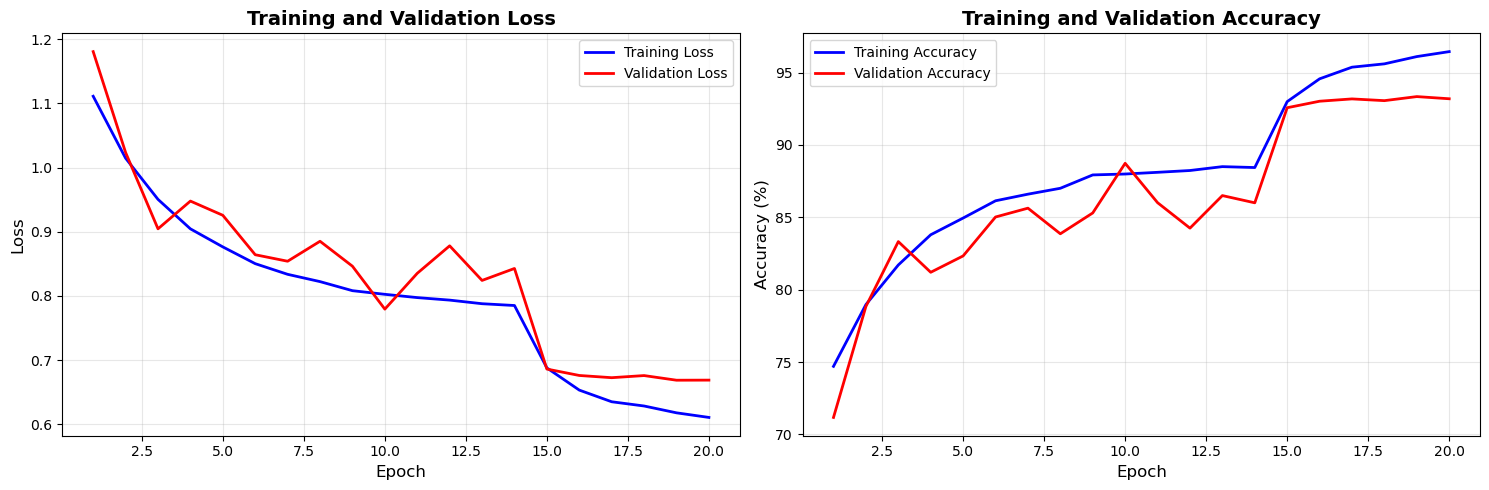

In [9]:
def plot_training_history(history):
    """
    Plot training and validation metrics over epochs.
    
    Creates two subplots:
    1. Loss curves (training and validation)
    2. Accuracy curves (training and validation)
    
    Args:
        history (dict): Training history with losses and accuracies
    """
    # Create figure with 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Create epoch range for x-axis
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot loss curves
    # Plot training loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    # Plot validation loss
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy curves
    # Plot training accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    # Plot validation accuracy
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


# PART 4: EVALUATION

### Test Set Evaluation

In [10]:
def evaluate_test_set(model, test_loader, criterion, device, model_path=None):
    """
    Evaluate model on test set.
    
    Loads best model weights and computes final test metrics.
    
    Args:
        model (nn.Module): Model to evaluate
        test_loader (DataLoader): Test data loader
        criterion: Loss function
        device: Device to use
        model_path (str): Path to saved model weights
    
    Returns:
        tuple: (test_loss, test_accuracy)
    """
    # Load best model weights if path provided
    if model_path:
        # Load state dictionary from file
        model.load_state_dict(torch.load(model_path))
        print(f"✓ Loaded model weights from: {model_path}")
    
    # Set model to evaluation mode 
    model.eval()

    # Initlize metrics 
    test_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation 
    with torch.no_grad():
        # Create progress bar for tested bataches
        test_pbar = tqdm(test_loader, desc='Testing')

        # Iterate through test beatches 
        for inputs, labels in test_pbar:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate metrics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            test_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.2f}%'
            })

            # Calculate final test metrics
    test_loss = test_loss / total
    test_acc = 100.0 * correct / total
    
    print("\n" + "="*80)
    print("TEST SET EVALUATION")
    print("="*80)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print("="*80)
    
    return test_loss, test_acc

# Evaluate on test set
test_loss, test_acc = evaluate_test_set(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    model_path='resnet50_cifar10_anti_overfitting.pth'
)



✓ Loaded model weights from: resnet50_cifar10_anti_overfitting.pth


/var/folders/kd/j0t_qpxn5232l1_zzhlcb2wc0000gn/T/ipykernel_28260/652730840.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]


TEST SET EVALUATION
Test Loss: 0.6750
Test Accuracy: 92.90%


### Confusion Matrix

Computing predictions:   0%|          | 0/157 [00:00<?, ?it/s]

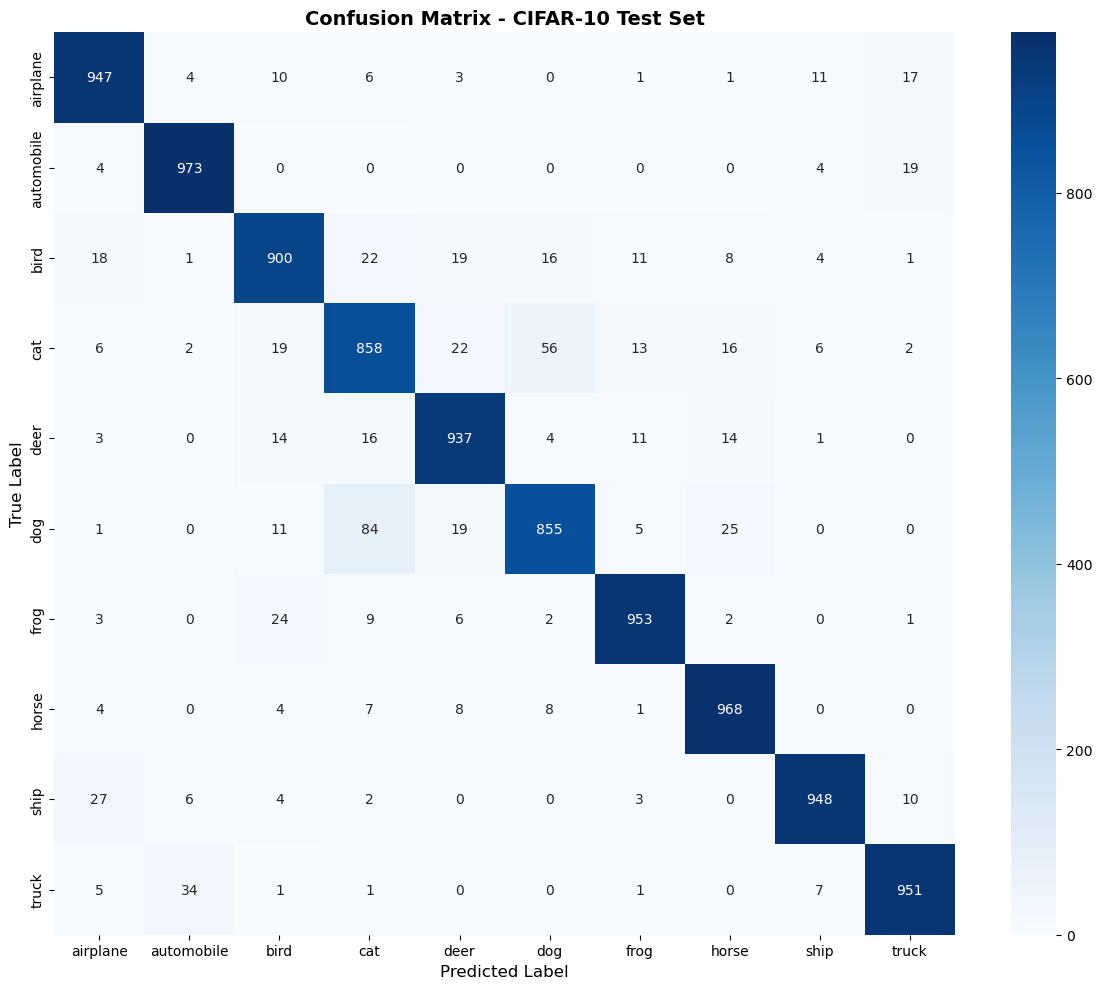


Per-Class Accuracy:
----------------------------------------
airplane    : 94.70% (947/1000)
automobile  : 97.30% (973/1000)
bird        : 90.00% (900/1000)
cat         : 85.80% (858/1000)
deer        : 93.70% (937/1000)
dog         : 85.50% (855/1000)
frog        : 95.30% (953/1000)
horse       : 96.80% (968/1000)
ship        : 94.80% (948/1000)
truck       : 95.10% (951/1000)


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, class_names, device):
    """
    Compute and plot confusion matrix for test set.
    
    Shows which classes are confused with each other.
    
    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test data loader
        class_names (list): List of class names
        device: Device to use
    """
    # Set model to evaluation mode
    model.eval()
    # Initialize lists for predictions and true labels
    all_preds = []
    all_labels = []

    # Disable gradient computation
    with torch.no_grad():
        # Iterate through test set
        for inputs, labels in tqdm(test_loader, desc='Computing predictions'):
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions and labels (move to CPU)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Create figure
    plt.figure(figsize=(12, 10))
    # Plot confusion matrix as heatmap
    sns.heatmap(
        cm,
        annot=True,  # Show numbers in cells
        fmt='d',  # Integer format
        cmap='Blues',  # Color scheme
        xticklabels=class_names,  # X-axis labels
        yticklabels=class_names  # Y-axis labels
    )
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix - CIFAR-10 Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Calculate per-class accuracy
    print("\nPer-Class Accuracy:")
    print("-" * 40)
    for i, class_name in enumerate(class_names):
        # Calculate accuracy for this class
        class_correct = cm[i, i]
        class_total = cm[i].sum()
        class_acc = 100.0 * class_correct / class_total
        print(f"{class_name:12s}: {class_acc:.2f}% ({class_correct}/{class_total})")
    
# Plot confusion matrix
plot_confusion_matrix(model, test_loader, class_names, device)

### Sample Predictions Visualization

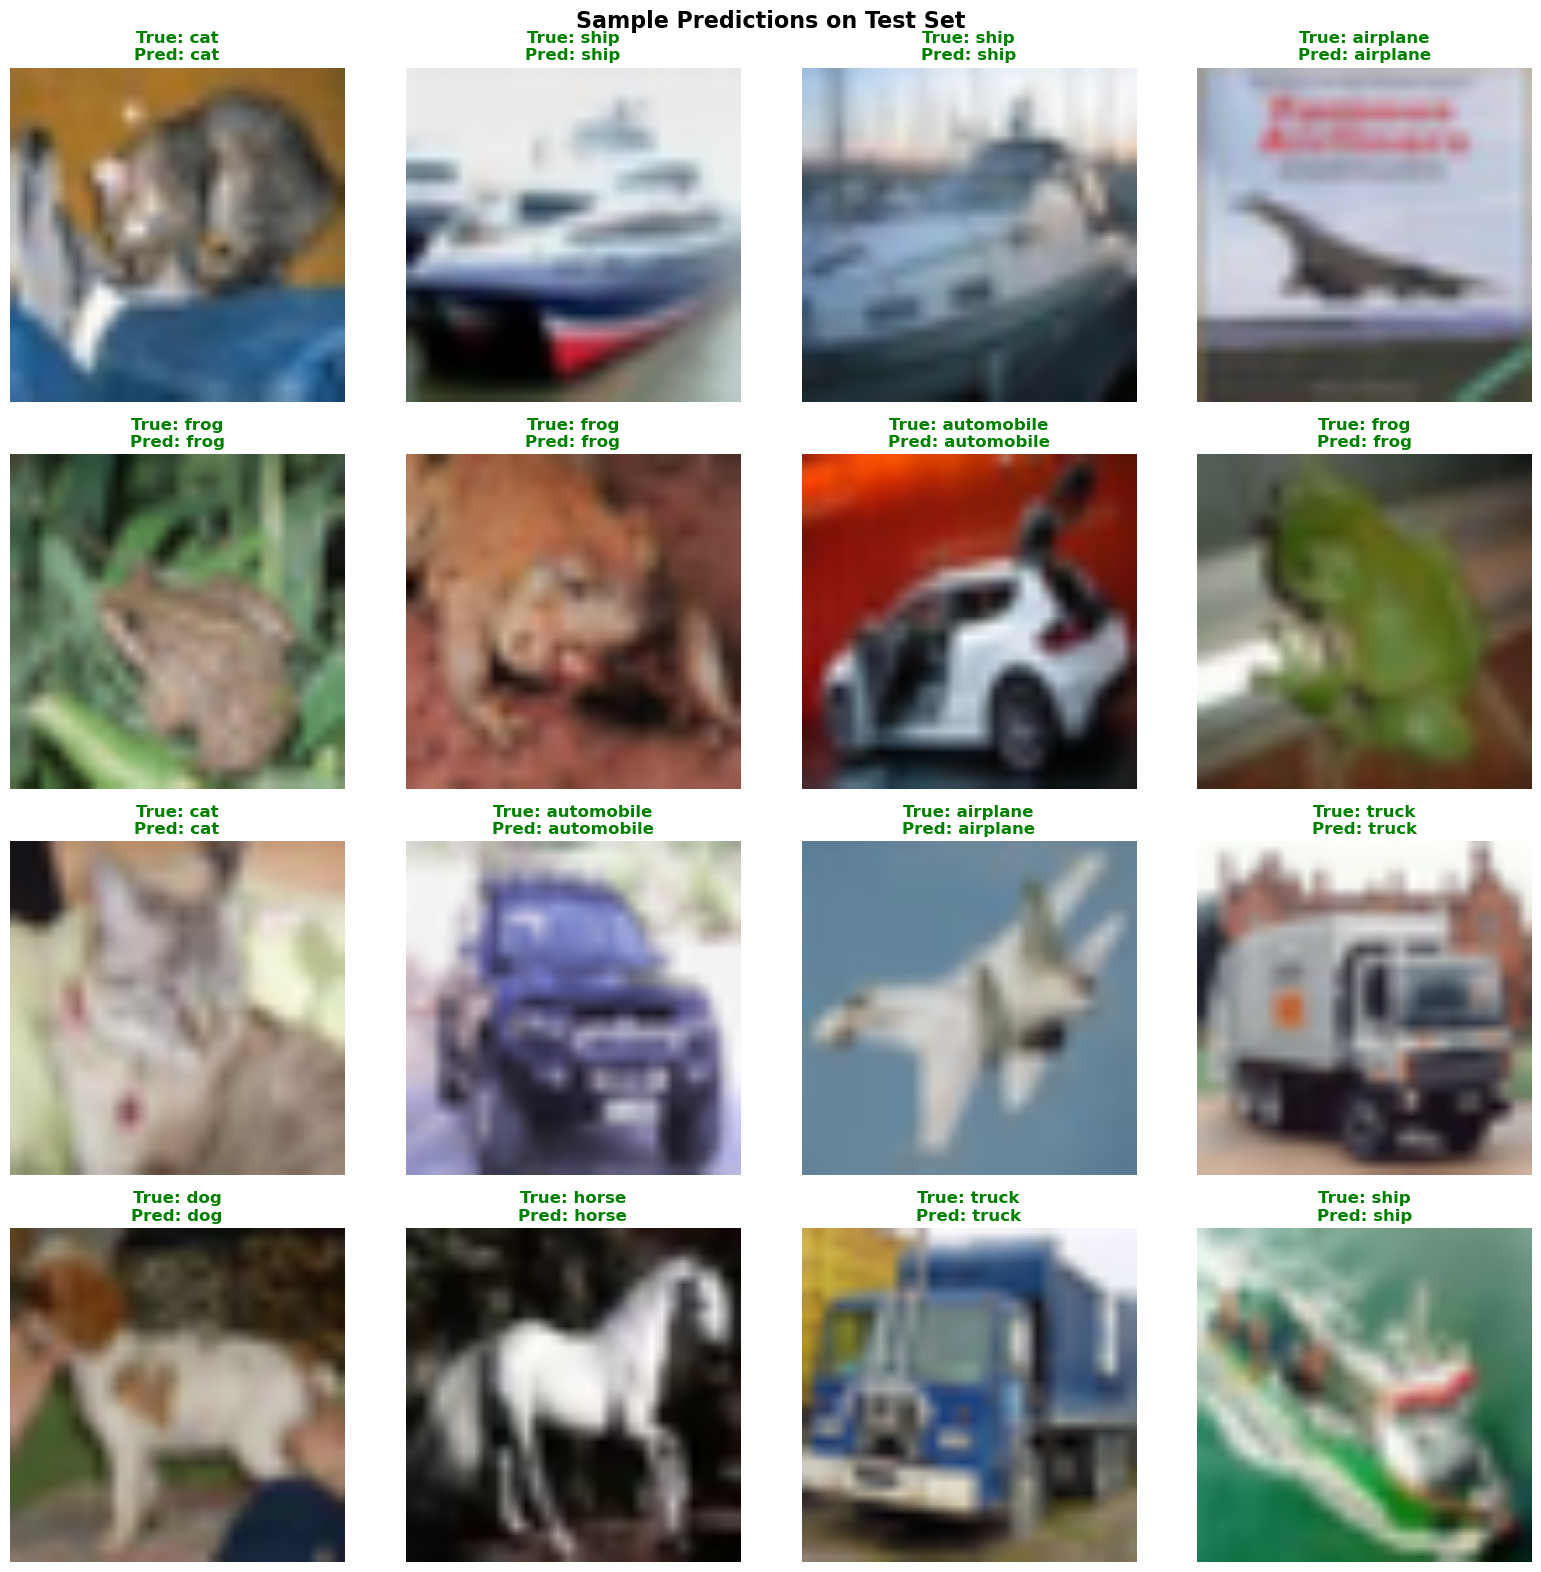

In [18]:
def visualize_predictions(model, test_loader, class_names, device, num_samples=16):
    """
    Visualize model predictions on random test samples.
    
    Shows images with true labels and predicted labels.
    Green = correct, Red = incorrect.
    
    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test data loader
        class_names (list): List of class names
        device: Device to use
        num_samples (int): Number of samples to display
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Move data to device and get predictions
    images_device = images.to(device)
    # Disable gradient computation
    with torch.no_grad():
        outputs = model(images_device)
        _, predictions = torch.max(outputs, 1)
    
    # Denormalization constants
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Create grid of subplots (4x4)
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold')
    
    # Display predictions for each sample
    for idx in range(num_samples):
        # Calculate subplot position
        ax = axes[idx // 4, idx % 4]
        
        # Denormalize image
        img = images[idx] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
        # Get true and predicted labels
        true_label = class_names[labels[idx]]
        pred_label = class_names[predictions[idx].cpu()]
        
        # Determine color (green if correct, red if wrong)
        color = 'green' if true_label == pred_label else 'red'
        
        # Display image
        ax.imshow(img)
        # Set title with true and predicted labels
        ax.set_title(f'True: {true_label}\nPred: {pred_label}', 
                     color=color, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_loader, class_names, device, num_samples=16)




# PART 5: EXPLAINABLE AI - GRAD-CAM

### Grad-CAM Implementation

In [13]:
import torch.nn.functional as F
import cv2

class GradCAM:
    """
    Grad-CAM implementation for ResNet-50.
    
    Algorithm:
    1. Forward pass: Get model predictions
    2. Backward pass: Compute gradients for target class
    3. Weight feature maps by gradient importance
    4. Generate heatmap overlay
    """
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM.
        
        Args:
            model (nn.Module): Trained ResNet-50
            target_layer (nn.Module): Layer to hook (model.layer4[-1] for ResNet-50)
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks to capture gradients and activations
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self,module,input,output):
        """Hook to save forward pass activations."""
        self.activations = output.detach()
    
    def _save_gradient(self,module,grad_input,grad_output):
        """Hook to save backward pass gradients."""
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class):
        """
        Generate Grad-CAM heatmap for a single image.
        
        Args:
            input_image (torch.Tensor): Preprocessed image (1, 3, 224, 224)
            target_class (int): Target class index (0-9 for CIFAR-10)
        
        Returns:
            np.ndarray: Heatmap (224, 224) with values [0, 1]
        """
        # Set model to evaluation mode
        self.model.eval()
        # Forward pass
        output = self.model(input_image)
        # Zero all gradients
        self.model.zero_grad()
        # Backward pass for target class
        output[0, target_class].backward()
        # Get gradients and activations
        gradients = self.gradients[0].cpu()
        activations = self.activations[0].cpu()
        # Global average pooling of gradients (importance weights)
        weights = torch.mean(gradients, dim=(1, 2))

        # Weighted sum of activations
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        # Apply ReLU
        cam = F.relu(cam)
        # Normalize to [0,1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        # Resize to input image (224x224)
        cam = cam.numpy()
        cam = cv2.resize(cam, (224, 224))
        return cam
print("✓ Grad-CAM class implemented successfully")

✓ Grad-CAM class implemented successfully


# PART 6: EXPLAINABLE AI - LIME

### LIME Implementation

In [14]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def batch_predict(images, model, device):
    """
    Batch prediction function for LIME.
    
    Args:
        images (np.ndarray): Batch of images (N, H, W, C) in [0, 1]
        model: PyTorch model
        device: Computation device
    
    Returns:
        np.ndarray: Prediction probabilities (N, 10)
    """
    model.eval()
    
    # Preprocessing: normalize with ImageNet stats
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Convert to PyTorch format: (N, H, W, C) -> (N, C, H, W)
    images_normalized = (images - mean) / std
    images_tensor = torch.from_numpy(images_normalized).permute(0, 3, 1, 2).float().to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images_tensor)
        probs = F.softmax(outputs, dim=1)
    
    return probs.cpu().numpy()

print("✓ LIME prediction wrapper implemented successfully")

✓ LIME prediction wrapper implemented successfully


# PART 7: COMPARATIVE ANALYSIS

### Grad-CAM vs. LIME Side-by-Side Comparison


GRAD-CAM vs. LIME COMPARISON


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

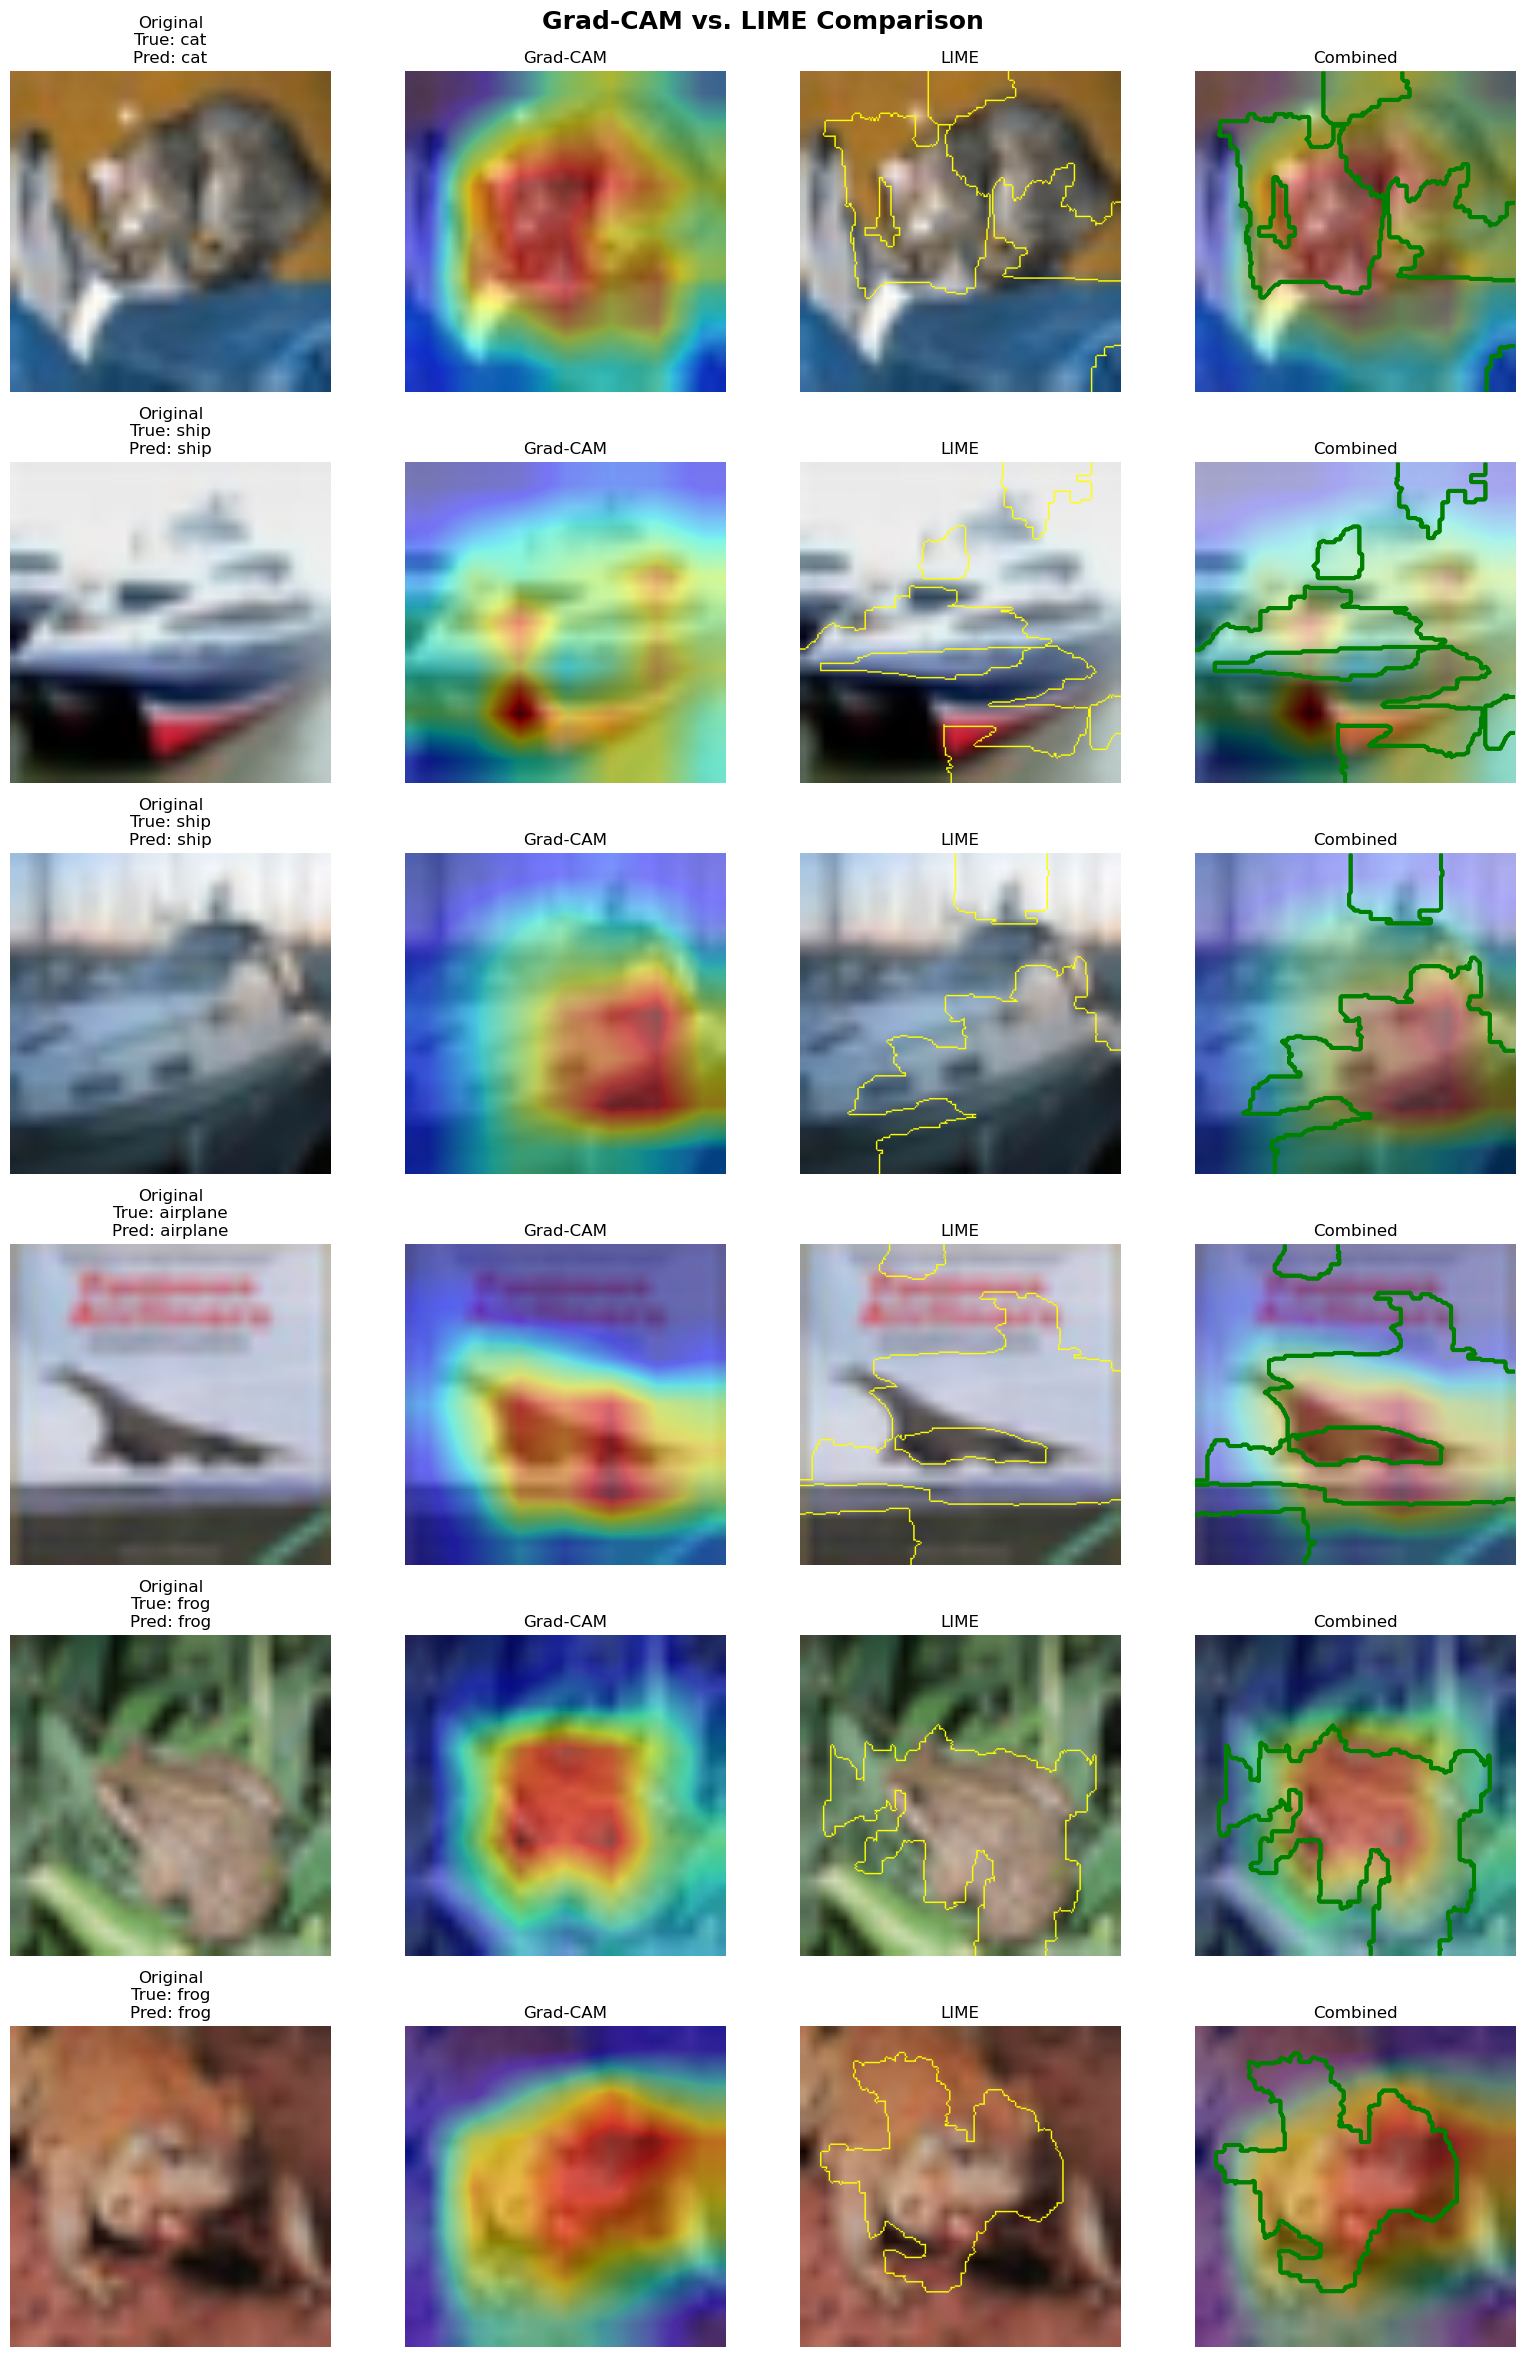

✓ Comparative visualization completed


In [15]:
def compare_gradcam_lime(model, test_loader, class_names, device, num_samples=6):
    """
    Side-by-side comparison of Grad-CAM and LIME.
    
    Creates a grid with 4 columns:
    1. Original image
    2. Grad-CAM heatmap
    3. LIME superpixels
    4. Overlay comparison
    
    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test data
        class_names (list): CIFAR-10 class names
        device: Computation device
        num_samples (int): Number of images to compare
    """
    # Initialize Grad-CAM and LIME
    grad_cam = GradCAM(model, target_layer=model.layer4[-1])
    lime_explainer = lime_image.LimeImageExplainer()
    
    # Get test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Denormalization constants
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))
    fig.suptitle('Grad-CAM vs. LIME Comparison', fontsize=18, fontweight='bold')
    
    for idx in range(num_samples):
        # Prepare image
        img_tensor = images[idx].unsqueeze(0).to(device)
        img_denorm = images[idx] * std + mean
        img_denorm = torch.clamp(img_denorm, 0, 1)
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        # Get prediction
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            pred_class = output.argmax(dim=1).item()
        
        # Generate Grad-CAM
        cam = grad_cam.generate_cam(img_tensor, pred_class)
        
        # Generate LIME
        lime_explanation = lime_explainer.explain_instance(
            img_np,
            lambda x: batch_predict(x, model, device),
            top_labels=1,
            hide_color=0,
            num_samples=1000
        )
        temp, mask = lime_explanation.get_image_and_mask(
            pred_class,
            positive_only=True,
            num_features=10,
            hide_rest=False
        )
        
        # Column 1: Original
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f'Original\nTrue: {class_names[labels[idx]]}\nPred: {class_names[pred_class]}')
        axes[idx, 0].axis('off')
        
        # Column 2: Grad-CAM
        axes[idx, 1].imshow(img_np)
        axes[idx, 1].imshow(cam, cmap='jet', alpha=0.5)
        axes[idx, 1].set_title('Grad-CAM')
        axes[idx, 1].axis('off')
        
        # Column 3: LIME
        axes[idx, 2].imshow(mark_boundaries(temp, mask))
        axes[idx, 2].set_title('LIME')
        axes[idx, 2].axis('off')
        
        # Column 4: Both overlaid
        axes[idx, 3].imshow(img_np)
        axes[idx, 3].imshow(cam, cmap='jet', alpha=0.3)
        axes[idx, 3].contour(mask, colors='green', linewidths=2)
        axes[idx, 3].set_title('Combined')
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Compare methods
print("\n" + "="*80)
print("GRAD-CAM vs. LIME COMPARISON")
print("="*80)
compare_gradcam_lime(model, test_loader, class_names, device, num_samples=6)
print("✓ Comparative visualization completed")

### Quantitative Comparison Metrics


RUNNING STRATIFIED QUANTITATIVE ANALYSIS
✓ Found 2 samples for all 10 classes!

Sample distribution:
  airplane    : 2 samples
  automobile  : 2 samples
  bird        : 2 samples
  cat         : 2 samples
  deer        : 2 samples
  dog         : 2 samples
  frog        : 2 samples
  horse       : 2 samples
  ship        : 2 samples
  truck       : 2 samples

Computing IoU for stratified samples...


Classes:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


QUANTITATIVE COMPARISON METRICS (STRATIFIED)

Overall Statistics:
  Mean IoU: 0.357
  Median IoU: 0.347
  Std Dev: 0.091
  Min IoU: 0.225
  Max IoU: 0.514

Per-Class IoU (ALL 10 CLASSES):
----------------------------------------
airplane    : 0.414 (n=2)
automobile  : 0.504 (n=2)
bird        : 0.286 (n=2)
cat         : 0.304 (n=2)
deer        : 0.262 (n=2)
dog         : 0.318 (n=2)
frog        : 0.467 (n=2)
horse       : 0.297 (n=2)
ship        : 0.372 (n=2)
truck       : 0.346 (n=2)


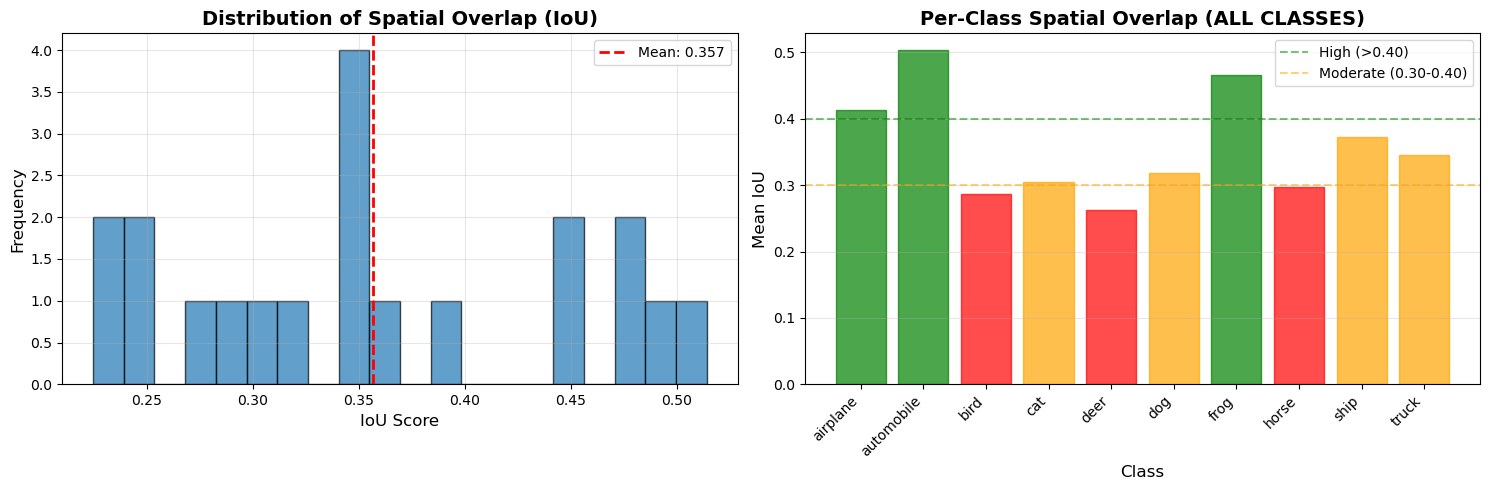


INTERPRETATION
~ MODERATE AGREEMENT: Grad-CAM and LIME show partial overlap
  Methods agree on some regions but differ in specifics

CLASS-SPECIFIC INSIGHTS

✅ HIGH AGREEMENT (IoU > 0.40):
  • airplane    : 0.414
  • automobile  : 0.504
  • frog        : 0.467
  → These classes have stable, discriminative features

🟡 MODERATE AGREEMENT (IoU 0.30-0.40):
  • cat         : 0.304
  • dog         : 0.318
  • ship        : 0.372
  • truck       : 0.346
  → These classes use feature ensembles or context

⚠️ LOW AGREEMENT (IoU < 0.30):
  • bird        : 0.286
  • deer        : 0.262
  • horse       : 0.297
  → These classes lack stable features (model uncertain)


In [17]:
def compute_quantitative_metrics_stratified(model, test_loader, class_names, device, samples_per_class=2):
    """
    Compute quantitative metrics with STRATIFIED sampling (guaranteed coverage of all classes).
    
    Ensures 2 samples per class → 20 total samples covering all 10 CIFAR-10 classes.
    
    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test data
        class_names (list): CIFAR-10 class names
        device: Computation device
        samples_per_class (int): Number of samples per class (default: 2)
    """
    # Initialize
    grad_cam = GradCAM(model, target_layer=model.layer4[-1])
    lime_explainer = lime_image.LimeImageExplainer()
    
    # Denormalization constants
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # STEP 1: Collect samples for each class (stratified sampling)
    print("Collecting stratified samples (2 per class)...")
    class_samples = {i: [] for i in range(10)}
    
    for images, labels in test_loader:
        for idx, label in enumerate(labels):
            class_idx = label.item()
            # Only collect if we need more samples for this class
            if len(class_samples[class_idx]) < samples_per_class:
                class_samples[class_idx].append((images[idx], label))
        
        # Stop once ALL classes have enough samples
        if all(len(samples) >= samples_per_class for samples in class_samples.values()):
            print("✓ Found 2 samples for all 10 classes!")
            break
    
    # Verify coverage
    print("\nSample distribution:")
    for class_idx in range(10):
        print(f"  {class_names[class_idx]:12s}: {len(class_samples[class_idx])} samples")
    
    # STEP 2: Compute IoU for collected samples
    iou_scores = []
    class_iou = {i: [] for i in range(10)}
    
    print("\nComputing IoU for stratified samples...")
    for class_idx in tqdm(range(10), desc='Classes'):
        for img_tensor, true_label in class_samples[class_idx]:
            # Prepare image
            img_tensor_device = img_tensor.unsqueeze(0).to(device)
            img_denorm = img_tensor * std + mean
            img_denorm = torch.clamp(img_denorm, 0, 1)
            img_np = img_denorm.permute(1, 2, 0).numpy()
            
            # Get prediction
            model.eval()
            with torch.no_grad():
                output = model(img_tensor_device)
                pred_class = output.argmax(dim=1).item()
            
            # Generate Grad-CAM (binarize top 30% pixels)
            cam = grad_cam.generate_cam(img_tensor_device, pred_class)
            gradcam_mask = (cam > np.percentile(cam, 70)).astype(int)
            
            # Generate LIME
            lime_explanation = lime_explainer.explain_instance(
                img_np,
                lambda x: batch_predict(x, model, device),
                top_labels=1,
                hide_color=0,
                num_samples=1000
            )
            _, lime_mask = lime_explanation.get_image_and_mask(
                pred_class,
                positive_only=True,
                num_features=10,
                hide_rest=False
            )
            lime_mask = lime_mask.astype(int)
            
            # Compute IoU
            intersection = np.logical_and(gradcam_mask, lime_mask).sum()
            union = np.logical_or(gradcam_mask, lime_mask).sum()
            iou = intersection / union if union > 0 else 0
            
            iou_scores.append(iou)
            class_iou[class_idx].append(iou)
    
    # Print results
    print("\n" + "="*80)
    print("QUANTITATIVE COMPARISON METRICS (STRATIFIED)")
    print("="*80)
    
    print(f"\nOverall Statistics:")
    print(f"  Mean IoU: {np.mean(iou_scores):.3f}")
    print(f"  Median IoU: {np.median(iou_scores):.3f}")
    print(f"  Std Dev: {np.std(iou_scores):.3f}")
    print(f"  Min IoU: {np.min(iou_scores):.3f}")
    print(f"  Max IoU: {np.max(iou_scores):.3f}")
    
    print(f"\nPer-Class IoU (ALL 10 CLASSES):")
    print("-" * 40)
    for class_idx in range(10):
        mean_iou = np.mean(class_iou[class_idx])
        print(f"{class_names[class_idx]:12s}: {mean_iou:.3f} (n={len(class_iou[class_idx])})")
    
    # Visualize IoU distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of IoU scores
    ax1.hist(iou_scores, bins=20, edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(iou_scores), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(iou_scores):.3f}')
    ax1.set_xlabel('IoU Score', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Spatial Overlap (IoU)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Per-class IoU bar chart (NOW WITH ALL 10 CLASSES!)
    class_means = [np.mean(class_iou[i]) for i in range(10)]
    bars = ax2.bar(range(10), class_means, edgecolor='black', alpha=0.7)
    
    # Color bars by IoU level
    for i, bar in enumerate(bars):
        if class_means[i] > 0.40:
            bar.set_color('green')
        elif class_means[i] > 0.30:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(class_names, rotation=45, ha='right')
    ax2.set_xlabel('Class', fontsize=12)
    ax2.set_ylabel('Mean IoU', fontsize=12)
    ax2.set_title('Per-Class Spatial Overlap (ALL CLASSES)', fontsize=14, fontweight='bold')
    ax2.axhline(0.40, color='green', linestyle='--', alpha=0.5, label='High (>0.40)')
    ax2.axhline(0.30, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.30-0.40)')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    print("\n" + "="*80)
    print("INTERPRETATION")
    print("="*80)
    if np.mean(iou_scores) > 0.4:
        print("✓ HIGH AGREEMENT: Grad-CAM and LIME show strong spatial overlap")
        print("  Both methods focus on similar image regions")
    elif np.mean(iou_scores) > 0.25:
        print("~ MODERATE AGREEMENT: Grad-CAM and LIME show partial overlap")
        print("  Methods agree on some regions but differ in specifics")
    else:
        print("⚠ LOW AGREEMENT: Grad-CAM and LIME show different focus regions")
        print("  Methods may be capturing different aspects of the decision")
    
    # Class-specific insights
    print("\n" + "="*80)
    print("CLASS-SPECIFIC INSIGHTS")
    print("="*80)
    
    high_agreement = [i for i in range(10) if np.mean(class_iou[i]) > 0.40]
    moderate_agreement = [i for i in range(10) if 0.30 <= np.mean(class_iou[i]) <= 0.40]
    low_agreement = [i for i in range(10) if np.mean(class_iou[i]) < 0.30]
    
    if high_agreement:
        print(f"\n✅ HIGH AGREEMENT (IoU > 0.40):")
        for idx in high_agreement:
            print(f"  • {class_names[idx]:12s}: {np.mean(class_iou[idx]):.3f}")
        print("  → These classes have stable, discriminative features")
    
    if moderate_agreement:
        print(f"\n🟡 MODERATE AGREEMENT (IoU 0.30-0.40):")
        for idx in moderate_agreement:
            print(f"  • {class_names[idx]:12s}: {np.mean(class_iou[idx]):.3f}")
        print("  → These classes use feature ensembles or context")
    
    if low_agreement:
        print(f"\n⚠️ LOW AGREEMENT (IoU < 0.30):")
        for idx in low_agreement:
            print(f"  • {class_names[idx]:12s}: {np.mean(class_iou[idx]):.3f}")
        print("  → These classes lack stable features (model uncertain)")
    
    print("="*80)

# Run stratified analysis
print("\n" + "="*80)
print("RUNNING STRATIFIED QUANTITATIVE ANALYSIS")
print("="*80)
compute_quantitative_metrics_stratified(model, test_loader, class_names, device, samples_per_class=2)

